# Exercise: solving the advection equation

## Problem setting
* Our goal is to solve the 1D advection equation $$u_t + a u_x = 0$$ for 
$u(x,t):\mathbb{R}\times\mathbb{R}^+\rightarrow\mathbb{R}$ and $a>0$
* This is an hyperbolic PDE
* We use the Lax-Friedrichs method defined by
$$
  U_j^{n+1} = \frac{1}{2}\left( U_{j-1}^n + U_{j+1}^n \right) 
  - \frac{\Delta t}{2\Delta x} a \left(U_{j+1}^n - U_{j-1}^n \right),
$$
where $U_j^{n} = u(x_j, t_n)$ and we assume an equidistant grid
$x_j = j \Delta x$, $t_n = n \Delta t$.
* This method can be derived either in a finite-volume or finite-difference framework.
* This method is stable (i.e., errors do not grow) for
$$
\left| \frac{\Delta t}{\Delta x} a \right| < 1
$$
or 
$$
\Delta t < \left| \frac{\Delta x}{a} \right|
$$
* Assume periodic boundary conditions.

## Exercise
1. Complete the python implementation.
2. Speed the code up by using operations over numpy arrays.
3. Reach a further speed-up by using Cython and Numba.
4. Examine properties of the solver for different initial conditions and different CFL values.
5. Extend to 2D.

## General code infrastructure

In [49]:
import numpy as np
import matplotlib.pyplot as plt

class Mesh:
    def __init__(self, Nx=1000, L=10, a=2, cfl=0.9, ic_type=1, do_plot=True):
        self.Nx = Nx
        self.Nx_total = Nx + 2
        self.deltax = 2.*L/Nx
        # include one boundary cell at each end
        self.x = np.arange(-1, Nx+1) * self.deltax - L
        # ensure stability criterion is fulfilled
        self.deltat = np.abs(self.deltax / a) * cfl
        # multiplication factor for time evolution
        self.alpha = a * self.deltat / (2.*self.deltax)
        self.set_initial_conditions(ic_type)
        self.u_tmp = np.zeros_like(self.u)
        if do_plot:
            self.plotter = Plotter()
        
    def set_initial_conditions(self, type=1):
        if type==1:
            self.u = np.zeros_like(self.x)
            self.u[self.x <= 0.0] = 1.0
        else:
            raise ValueError("Type {:d} not known.".format(type))

class Plotter:
    def __init__(self):
        self.f = plt.figure()
        self.ax = plt.subplot(111)
        self.ax.set_xlabel('$x$')
        self.ax.set_ylabel('$u$')
        
    def update(self, mesh, time):
        self.ax.plot(mesh.x[1:-1], mesh.u[1:-1], label=time)
        self.ax.legend()
                
            
def time_evolution(do_timestep, mesh, initial_time=0.0,
                   number_steps=200, number_plots=10):
    current_time = initial_time
    mesh.plotter.update(mesh, current_time)
    for n_step in range(number_steps):
        do_timestep(mesh)
        # swap u and u_tmp
        u_swap = mesh.u
        mesh.u = mesh.u_tmp
        mesh.u_tmp = u_swap
        current_time += mesh.deltat
        if n_step % (number_steps//number_plots) == 0:
            mesh.plotter.update(mesh, current_time)

## 1. The python implementation

CPU times: user 306 ms, sys: 0 ns, total: 306 ms
Wall time: 306 ms


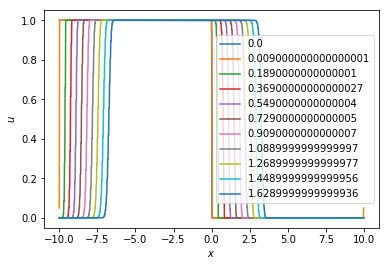

In [50]:
def timestep_python(mesh):
    # boundaries
    mesh.u[-1] = mesh.u[1]
    mesh.u[0] = mesh.u[-2]
    # main loop
    for j in range(1, mesh.Nx + 1):
        mesh.u_tmp[j] = 0.5*(mesh.u[j-1] + mesh.u[j+1]) -\
            mesh.alpha * (mesh.u[j+1] - mesh.u[j-1])

mesh_py = Mesh(cfl=0.9)
%time time_evolution(timestep_python, mesh_py)

## 2. Implementation using numpy arrays

CPU times: user 81.9 ms, sys: 54 µs, total: 82 ms
Wall time: 81.6 ms


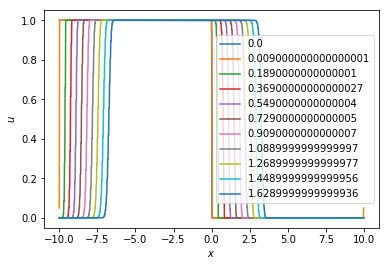

In [51]:
def timestep_numpy(mesh):
    # boundaries
    mesh.u[-1] = mesh.u[1]
    mesh.u[0] = mesh.u[-2]
    # main loop
    mesh.u_tmp[1:-1] = 0.5*(mesh.u[:-2] + mesh.u[2:]) -\
            mesh.alpha * (mesh.u[2:] - mesh.u[:-2])

mesh_np = Mesh(cfl=0.9)
%time time_evolution(timestep_numpy, mesh_np)

## 3a. Cython implementation

In [52]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [53]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.float64_t DTYPE_t

def timestep_cython(mesh):
    do_timestep_cython(mesh.u, mesh.u_tmp, mesh.alpha)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def do_timestep_cython(np.ndarray[DTYPE_t, ndim=1] u, np.ndarray[DTYPE_t, ndim=1] u_tmp,
                       DTYPE_t alpha):
    cdef int j
    # boundaries
    u[u.shape[0]-1] = u[1]
    u[0] = u[u.shape[0]-2]
    # main loop
    for j in range(1, u.shape[0]-1):
        u_tmp[j] = 0.5*(u[j-1] + u[j+1]) - alpha * (u[j+1] - u[j-1])

CPU times: user 90.1 ms, sys: 58 µs, total: 90.2 ms
Wall time: 90.1 ms


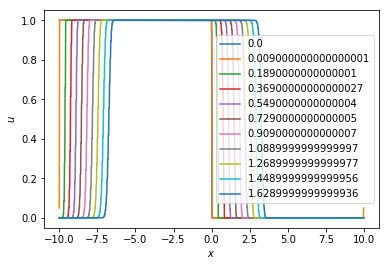

In [54]:
mesh_cy = Mesh(cfl=0.9)
%time time_evolution(timestep_cython, mesh_cy)

## 3b. Numba implementations

CPU times: user 52.7 ms, sys: 13 µs, total: 52.7 ms
Wall time: 52.7 ms


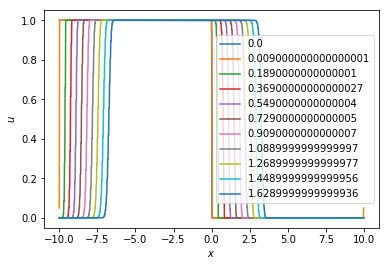

In [55]:
from numba import jit

@jit(nopython=True, fastmath=True)
def c_timestep_python_numba(u, u_tmp, alpha):
    # boundaries
    u[-1] = u[1]
    u[0] = u[-2]
    # main loop
    for j in range(1, u.shape[0]-1):
        u_tmp[j] = 0.5*(u[j-1] + u[j+1]) -\
            alpha * (u[j+1] - u[j-1])

def timestep_python_numba(mesh):
    """Wrapper to pass only NumPy datatypes to the jitted function."""
    c_timestep_python_numba(mesh.u, mesh.u_tmp, mesh.alpha)
        
timestep_python_numba(Mesh(cfl=0.9, do_plot=False))  # call once to trigger compilation
mesh_py_numba = Mesh(cfl=0.9)
%time time_evolution(timestep_python_numba, mesh_py_numba)

CPU times: user 197 ms, sys: 1e+03 ns, total: 197 ms
Wall time: 197 ms


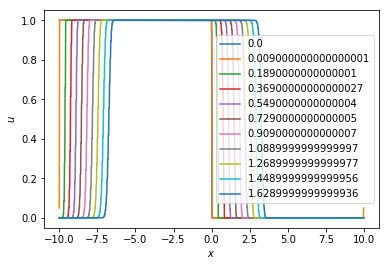

In [56]:
from numba import jit

@jit(nopython=True, fastmath=True)
def c_timestep_numpy_numba(u, u_tmp, alpha):
    # boundaries
    u[-1] = u[1]
    u[0] = u[-2]
    # main loop
    u_tmp[1:-1] = 0.5*(u[:-2] + u[2:]) - \
            alpha * (u[2:] - u[:-2])

def timestep_numpy_numba(mesh):
    c_timestep_python_numba(mesh.u, mesh.u_tmp, mesh.alpha)
        
timestep_numpy_numba(Mesh(cfl=0.9, do_plot=False))  # call once to trigger compilation
mesh_np_numba = Mesh(cfl=0.9)
%time time_evolution(timestep_numpy_numba, mesh_np_numba)

## 4. Different ICs and CFL factors

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms
CPU times: user 55 ms, sys: 0 ns, total: 55 ms
Wall time: 55 ms


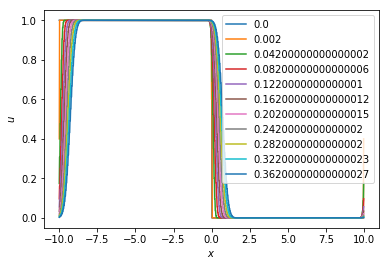

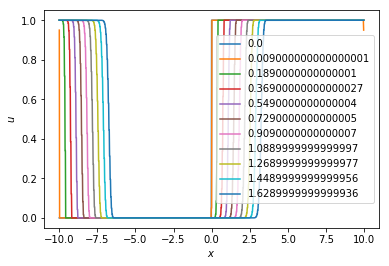

In [57]:
def timestep_numpy(mesh):
    # boundaries
    mesh.u[-1] = mesh.u[1]
    mesh.u[0] = mesh.u[-2]
    # main loop
    mesh.u_tmp[1:-1] = 0.5*(mesh.u[:-2] + mesh.u[2:]) -\
            mesh.alpha * (mesh.u[2:] - mesh.u[:-2])

mesh_np = Mesh(cfl=0.2)
%time time_evolution(timestep_numpy, mesh_np)

class Mesh2(Mesh):
    def set_initial_conditions(self, type=1):
        if type==1:
            self.u = np.zeros_like(self.x)
            self.u[self.x <= 0.0] = 1.0
        elif type==2:
            self.u = np.zeros_like(self.x)
            self.u[self.x >= 0.0] = 1.0
        else:
            raise ValueError("Type {:d} not known.".format(type))

mesh_np = Mesh2(cfl=0.9, ic_type=2)
%time time_evolution(timestep_numpy, mesh_np)

## 5. Extend to 2D
* new Mesh and Plotter classes needed
* new timestepper functions needed